### RNN with LSTM cell
* Architecture reference from https://arxiv.org/pdf/2004.00959.pdf
* Trained on all countries data

(Something new: Maybe decrease number of classifier by grouping countries in the same GDP/ bracket)

#### Data partition
* Test data is the last 10 days
* Validation 10 days before last 10 days
* Data logged

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [2]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()

In [3]:
countries
df_csse.shape

(171, 81)

#### What if use grouping from k-means? or hierarchical clustering to decide which countries are in the same bracket


In [4]:
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

79
(171, 5)
(171, 5)
(171, 69)


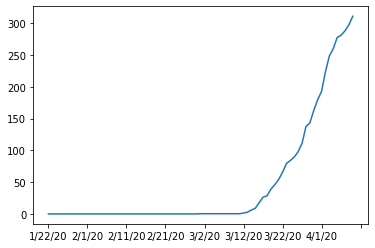

In [5]:
# plot 
#epoch = np.linspace(1, len(trainErr), len(trainErr))

cases.loc[50,:].plot.line()


In [6]:
case_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.41700405e+01, 1.82186235e+01, 1.82186235e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.69184222e+00, 3.38368444e+00, 3.38368444e+00],
       ...,
       [3.02112385e-03, 3.02112385e-03, 6.04224770e-03, ...,
        3.66960808e+02, 4.25703540e+02, 4.88911494e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91862032e+05, 1.91862032e+05, 1.91862032e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.77039570e+02, 9.77039570e+02, 9.77039570e+02]])

In [7]:
# log transform
case_test_log = np.log(case_test)
case_validation_log = np.log(case_validation)
case_train_log = np.log(case_train)
case_train_log

/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


array([[       -inf,        -inf,        -inf, ...,        -inf,
               -inf,        -inf],
       [       -inf,        -inf,        -inf, ...,  2.65112991,
         2.90244434,  2.90244434],
       [       -inf,        -inf,        -inf, ...,  0.52581801,
         1.21896519,  1.21896519],
       ...,
       [-5.80212638, -5.80212638, -5.1089792 , ...,  5.90525505,
         6.05374319,  6.19218148],
       [       -inf,        -inf,        -inf, ..., 12.16453181,
        12.16453181, 12.16453181],
       [       -inf,        -inf,        -inf, ...,  6.88452715,
         6.88452715,  6.88452715]])

### Divide data into training sets
* specify number of days for train and prediction
* offset the dataset so for example: [1,2,3,4] then get [1,2],[2,3] which predicts 3 and 4 respectively

In [8]:
# test 
np.array(case_train[3,:])
#total_days-pred_days-t_days

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00869841, 0.00869841, 0.00869841, 0.04349203,
       0.04349203, 0.05219044, 0.05219044, 0.07828566, 0.07828566,
       0.09568248, 0.09568248, 0.10438088, 0.10438088, 0.10438088,
       0.13917451, 0.13917451, 0.18266655, 0.20006336])

In [9]:
t_days = 40
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []


for i in range(len(countries)):
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    for j in range(total_days-pred_days-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        #cur_c.append(case_train[i,j:j+t_days])
        #print(str(j))
        #out.append(case_train[i,j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
        country_train_X.append(case_train[i,j:j+t_days])
        country_train_Y.append(case_train[i,j+t_days:j+t_days+pred_days])
    
    country_valid_X.append(case_train[i,-t_days:])
    country_valid_Y.append(case_validation[i])
    
    country_test_X.append(casesA[i,days-test_d-t_days:days-test_d])
    country_test_Y.append(case_test[i])


In [10]:
# check dimension

#len(country_test_X[33])
total_days-pred_days-test_d
pred_days
test_d
total_days
case_train[0,29:64].shape
case_train[0,0:40].shape

(40,)

In [11]:
len(country_train_X[1])
len(country_train_Y[1])
len(country_train_Y[1][0])
#len(country_test_Y[1])
#a = torch.tensor(country_train_X[10]).unsqueeze_(1).unsqueeze_(1)
#torch.max(torch.tensor(country_train_X[2])).item()
#torch.randn(a.shape[0],a.shape[1],a.shape[2])*0.05
#a+a

5

#### Data size & index
The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. We haven’t discussed mini-batching, so lets just ignore that and assume we will always have just 1 dimension on the second axis.

In [12]:
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Optimized hyperparameters
|Parameter |Description|Distribution/Selection|Values|
|----------|------------|----------------------|---------|
|Learning rate|Minimum learning rate| Log uniform|1e-1 to 1e-7|
|Hidden layers|Number of layers in the network|Discrete numeric|1 to 20|
|Hidden state|Number of memory cell in each layer|Discrete numeric|1 to 200|
|Activation|Activation in each layer|Category|{ReLu,sigmoid,tanh}|
|Batch size|Batch size during training|Discrete numeric|1 to 10|
|Dropout|Dropout size before dense layer|Log uniform|0 to 0.|

In [13]:
# Parameter
num_epochs = 100 # max
batch_size = 1
# Loss and optimizer
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate = 0.01 # to be changed/optimized 
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
output_directory = "mock/"
output_file_path = "mock/Train"
input_dim = t_days
hidden_dim = 2
hidden_state = 100
output_dim= pred_days
num_layers=2
lstm_input_size = t_days
#model = LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model_name = "mock"
output_file_path = "./outputs/" + model_name + "/training/"
directory = os.path.dirname(output_file_path)
if not os.path.exists(directory):
    print("Creating directory %s" % output_file_path)
    os.makedirs(directory)
else:
     print("Directory %s exists" % output_file_path)


Directory ./outputs/mock/training/ exists


In [14]:
# RNN structure

class RNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, data, last_hidden):
        input = torch.cat((data, last_hidden), 1)
        hidden = self.i2h(input)
        output = self.h2o(hidden)
        return hidden, output
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [15]:
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

In [16]:
# training function
def train_model(train_loader, test_loader, model, device, criterion, optimizer, num_epochs, output_directory,learning_rate,hidden_dim,num_layers):
    
    total_step = len(train_loader)
    model.train()
    model.hidden = model.init_hidden() # LSTM hidden reinitialization
    
    #open files to log error
    train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")
    test_error = open(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_valid = float('inf')
    best_epoch = 1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (seqs, labels) in enumerate(train_loader):
            #print(seqs.shape)
            # add gaussian noise to sequence
            noiselevel = torch.max(torch.tensor(country_train_X[2])).item()/1000
            noise = torch.randn(seqs.shape[0],seqs.shape[1],seqs.shape[2],seqs.shape[3])*noiselevel
            #print(noise.shape)
            seqs += noise # add gaussian noise
            #print(seqs.shape)
            seqs = seqs.to(device)
            labels = labels.to(device)

            # Forward pass
            #seqs = seqs.squeeze()
            #print(seqs.shape)
            #print(model(seqs))
            outputs = model(seqs) # error 
            loss = criterion(outputs, labels) # change input to 
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #save training loss to file
        epoch_loss = running_loss / len(train_loader.dataset)
        print("%s, %s" % (epoch, epoch_loss), file=train_error)
        
        #calculate test loss for epoch
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for i, (seqs, labels) in enumerate(test_loader):
                x = seqs.to(device)
                y = labels.to(device)
                outputs = model(x)
                #print(outputs.shape)
                #print(y.shape)
                loss = criterion(outputs, y)
                test_loss += loss.item() 
                
                # for metrics
                #updateYlist(outputs,y)
                

        test_loss = test_loss / len(test_loader.dataset)
        
        #save outputs for epoch
        print("%s, %s" % (epoch, test_loss), file=test_error)
        
        # for each epoch, calculate metrics (f1, pr)
        #calculateMetrics(outputs,y)
        
        if test_loss < best_loss_valid:
            best_loss_valid = test_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print ('Saving the best model weights at Epoch [{}], Best Valid Loss: {:.4f}' 
                       .format(epoch+1, best_loss_valid))

        
    train_error.close()
    test_error.close()

    #model.load_state_dict(best_model_wts)
    print("train error:", epoch_loss)
    return model, best_loss_valid


In [17]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss

In [18]:
#dimension check
a = torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2) #torch.Size([19, 30, 1, 1])
torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
#torch.tensor(country_train_Y[0])
torch.tensor(country_train_X[0])
a.size(-1)
torch.tensor(country_test_Y[0]).unsqueeze_(0).shape
torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
#torch.tensor(country_valid_Y[0]).unsqueeze_(0).unsqueeze_(0).shape
torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).shape
torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape

torch.Size([1, 40, 1, 1])

In [19]:
# test if it runs
learning_rate = 0.01 # to be changed/optimized 
num_layers = 2
hidden_dim = 100

net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
print(net)
model = net.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[0]).unsqueeze_(1).float())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# load validation
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[0]).unsqueeze_(0).float())
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

# load test
test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[0]).unsqueeze_(0).float())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# mock trial
err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim, num_layers)



LSTM(
  (lstm): LSTM(40, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=5, bias=True)
)


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Saving the best model weights at Epoch [1], Best Valid Loss: 0.0484
train error: 6.7692523542930635e-12


In [20]:
torch.tensor(country_train_Y[0]).unsqueeze_(0).shape


torch.Size([1, 24, 5])

In [ ]:
# optimization grid
lr_list = [0.1,0.01,0.001,0.005,1e-4,5e-4,1e-5,1e-6]
hidden_lst = [1,2,3,4,5]
hState_lst = [30,50,100,200,300]

country_result = dict()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
best_error = 1e10

for i in range(len(countries)):
    country_result[countries[i]] = [] # store best validation parameter, test loss, test result
    best_error = 1e10
    
    best_param = [0,0,0]

    learning_rate = lr_list[0] # to be changed/optimized 
    hidden_dim = hidden_lst[0]
    hidden_state = hState_lst[0]
    
    
    model_name = countries[i]
    output_file_path = "./outputs/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    if not os.path.exists(directory):
        print("Creating directory %s" % output_file_path)
        os.makedirs(directory)
    else:
         print("Directory %s exists" % output_file_path)

    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[i]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[i]).unsqueeze_(1).float())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # load validation
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[i]).unsqueeze_(0).float())
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

    # load test
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[i]).unsqueeze_(0).float())
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    bestmodel = 0
    
    # optimize (learning rate, hidden layer, hidden state, activation)
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                # train
                # specific parameters
                learning_rate = lr_list[j]
                hidden_dim = hState_lst[m]
                num_layers = hidden_lst[k]
                
                net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
                #print(net)
                model = net.to(device)
                
                #
                optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
                # to be changed/optimized 
                
                model, err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim,num_layers)
                print(err)
                if err < best_error:
                    best_error = err
                    best_param = [lr_list[j],hidden_lst[k],hState_lst[m]]
                    bestmodel = model
    
    country_result[countries[i]].append(best_param)
    
    # test data
    pred,final_loss = test_model(test_loader,bestmodel,device,criterion)
    print("test loss: ",final_loss)
    country_result[countries[i]].append([pred.tolist(),country_test_Y[i].tolist()])
    country_result[countries[i]].append(final_loss)
    torch.save(bestmodel.state_dict(), output_file_path+countries[i]+".th")

Directory ./outputs/Burundi/training/ exists
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0477
train error: 1.2224617261756092e-09
0.04767756909132004
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0494
train error: 3.541498357594042e-10
0.049432095140218735
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0493
train error: 2.5686448685650437e-10
0.049295779317617416
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0500
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0487
train error: 1.1491109431181756e-10
0.04872298240661621
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0494
train error: 8.300809974277901e-11
0.0493806600570

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0489
train error: 3.914692726149739e-17
0.04894004389643669
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0467
train error: 3.313604262530599e-17
0.04665930196642876
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0494
train error: 2.6179417088225853e-17
0.04944324493408203
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0464
train error: 1.771061195445542e-17
0.0464303158223629
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0623
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0604
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0587
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0573
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0561
Saving the best model weights at

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0506
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0502
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0500
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0500
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0498
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [60], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [61], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [68], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [75], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [76], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [77], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [78], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [79], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [80], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [81], Best Valid Loss: 0.0495
Saving the best model weights at E

In [ ]:
import json
with open("country_summary.js",'w+') as outfile:
    json.dump(country_result, outfile , sort_keys = True , indent = 4, separators = (",",": "))


In [ ]:
#country_test_Y[0]